In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go

import mlflow
from mlflow.entities import ViewType

In [28]:
mlflow.set_tracking_uri("http://localhost:5000")

runs = mlflow.search_runs(
    experiment_ids="1",
    run_view_type=ViewType.ALL
)
runs.columns

Index(['run_id', 'experiment_id', 'status', 'artifact_uri', 'start_time',
       'end_time', 'metrics.val_MAE', 'metrics.loss', 'metrics.val_MSE',
       'metrics.test_MSE', 'metrics.val_RMSE', 'metrics.mse',
       'metrics.test_MAE', 'metrics.test_RMSE', 'metrics.best_val_RMSE',
       'params.shuffle', 'params.opt_beta_1', 'params.opt_learning_rate',
       'params.opt_epsilon', 'params.kernel_weight', 'params.opt_decay',
       'params.sample_weight', 'params.kernel_regularizer',
       'params.validation_batch_size', 'params.steps_per_epoch',
       'params.class_weight', 'params.use_multiprocessing', 'params.opt_name',
       'params.opt_amsgrad', 'params.learning_rate', 'params.num_units',
       'params.epochs', 'params.validation_steps', 'params.workers',
       'params.max_queue_size', 'params.batch_size', 'params.validation_split',
       'params.activation', 'params.num_layers', 'params.validation_freq',
       'params.initial_epoch', 'params.opt_beta_2',
       'tags.mlflo

In [42]:
runs = pd.read_csv("../../data/runs.csv")

columns_of_interest = ['start_time', 'params.activation', 'params.epochs', 'params.learning_rate', 'params.kernel_weight', 'params.kernel_regularizer', 
        'params.num_layers', 'params.num_units', 'metrics.loss', 'metrics.mse',
       'metrics.test_MAE', 'metrics.test_MSE', 'metrics.test_RMSE', 'metrics.val_MAE', 'metrics.val_MSE', 'metrics.val_RMSE']
normalized_columsn = ['start_time', 'activation', 'epochs', 'learning_rate', 'kernel_weight', 'kernel_regularizer', 
        'num_layers', 'num_units', 'loss', 'mse',
       'test_MAE', 'test_MSE', 'test_RMSE', 'val_MAE', 'val_MSE', 'val_RMSE']
runs = runs[columns_of_interest]

runs = runs.set_index('start_time')
runs = runs.loc[:'2022-03-25']
runs = runs.dropna()

In [44]:
variables = ['activation', 'learning_rate', 'kernel_weight', 'kernel_regularizer', 'num_layers', 'num_units']
target = ["test_MSE"]

In [5]:
runs[runs["test_MSE"] == min(runs["test_MSE"])]

,Duration,activation,epochs,learning_rate,kernel_weight,kernel_regularizer,num_layers,num_units,loss,mse,test_MAE,test_MSE,test_RMSE,val_MAE,val_MSE,val_RMSE
Start Time,,,,,,,,,,,,,,,,
2022-03-26 12:34:16,12.7s,sigmoid,1.0,0.01,0.000001,l1,0.0,58.0,0.369403,0.115166,0.192329,0.096572,0.438553,0.203799,0.097888,0.451441


In [7]:
parr_coord_data = runs[variables + target]
parr_coord_data = parr_coord_data.replace({
     'l1': 0,
     'l2': 1,
     'relu': 0,
     'sigmoid': 1
})

fig = go.Figure(data=
     go.Parcoords(
          line = dict(color = parr_coord_data['test_MSE'],
                   showscale = True,
                   cmin = .1,
                   cmax = .25),
          dimensions = list([
               dict(range = [int(parr_coord_data['num_layers'].min()),int(parr_coord_data['num_layers'].max())],
                    label = "Num layers", values = parr_coord_data['num_layers']),
               dict(range = [int(parr_coord_data['num_units'].min()),int(parr_coord_data['num_units'].max())],
                    label = "Num units", values = parr_coord_data['num_units']),
               dict(range = [float(parr_coord_data['kernel_weight'].min()),float(parr_coord_data['kernel_weight'].max())],
                    label = "Kernel weight", values = parr_coord_data['kernel_weight']),
               dict(range = [float(parr_coord_data['learning_rate'].min()),float(parr_coord_data['learning_rate'].max())],
                    label = "Learning rate", values = parr_coord_data['learning_rate']),
               dict(tickvals = [0,1],
                    ticktext = ['relu','sigmoid'],
                    label = 'Activation function', values = parr_coord_data['activation']),
               dict(tickvals = [0,1],
                    ticktext = ['l1','l2'],
                    label = 'Kernel regularizer', values = parr_coord_data['kernel_regularizer']),
               dict(range = [float(parr_coord_data['test_MSE'].min()),float(parr_coord_data['test_MSE'].max())],
                    label = "MSE", values = parr_coord_data['test_MSE']),
          ])
    )
)
fig.show()

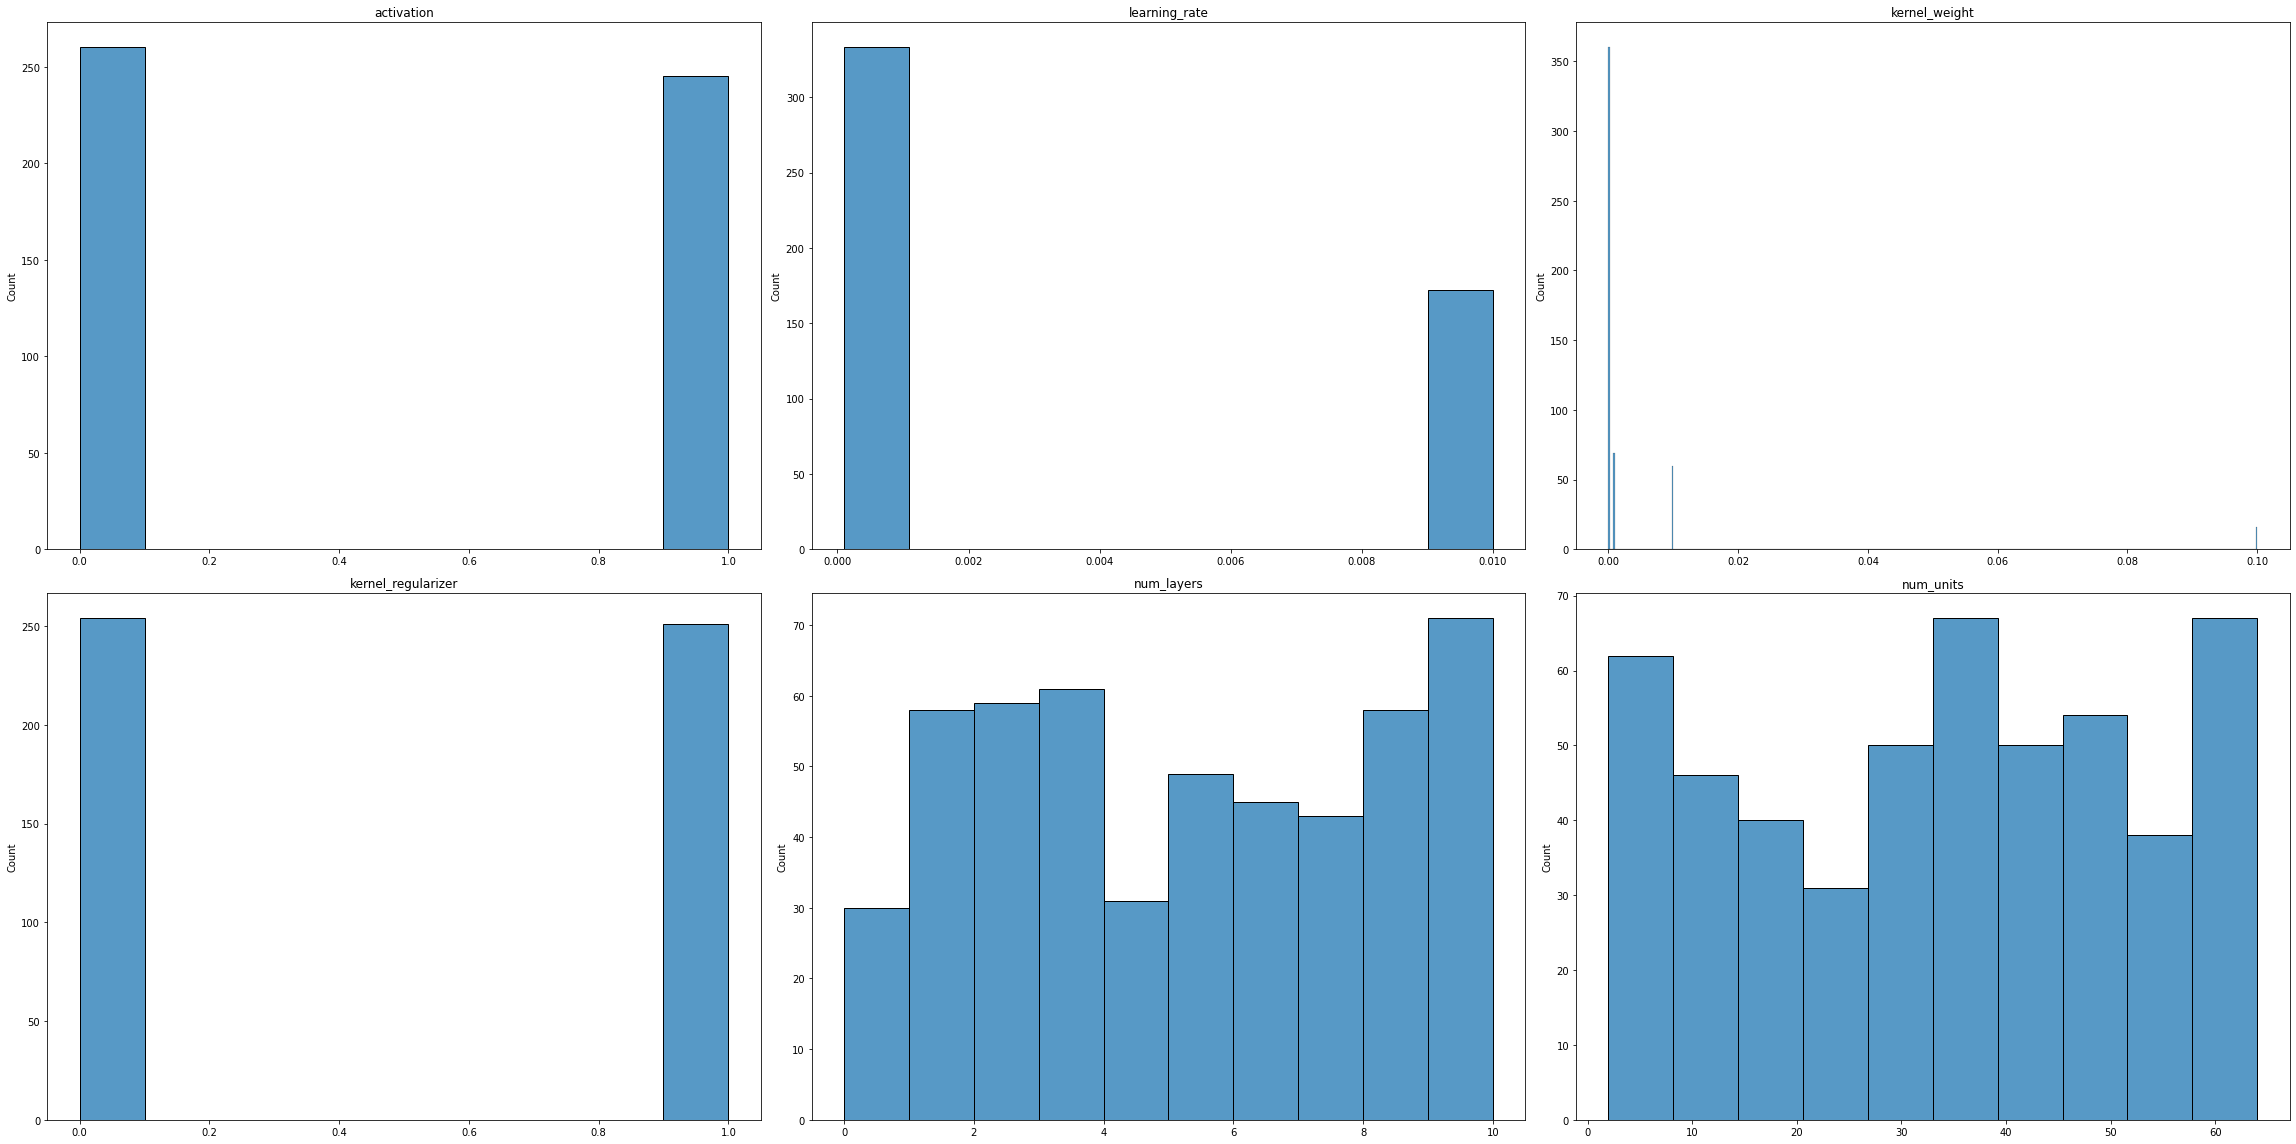

In [9]:
fig, axes = plt.subplots(2, 3, figsize=(32, 16))

for (ax, variable) in zip(axes.flatten(), variables):
    ax.set_title(variable)
    sns.histplot(x=parr_coord_data[variable].values, ax=ax)
plt.tight_layout()
plt.show()

0.001209629666615691
0.0011243793614499453


# Retrain the model with the optimal params

In [13]:
import tensorflow as tf
import keras

from keras.callbacks import EarlyStopping
from keras.layers import Dense, Input, Flatten
from keras.models import Sequential, load_model
from keras.regularizers import l2, l1
from scikeras.wrappers import KerasRegressor

In [14]:
def get_xy_split():
        data = pd.read_csv(
            "../../data/Lindel_training.txt", sep='\t', header=None)
        x_t = data.iloc[:, 1:3034]  # the full one hot encoding
        # 557 observed outcome frequencies
        y_t = data.iloc[:, 3034:]
        return np.array(x_t), np.array(y_t)

def prepare_data():
        x_t, y_t = get_xy_split()

        x_t = x_t[:, -384:]

        y_ins = np.sum(y_t[:, -21:], axis=1)
        y_del = np.sum(y_t[:, :-21], axis=1)

        y_t = np.array([[0, 1] if y_ins > y_del else [1, 0]
                        for y_ins, y_del in zip(y_ins, y_del)]).astype('float32')

        train_size = round(len(x_t) * 0.9)

        x_train, x_test = x_t[:train_size, :], x_t[train_size:, :]
        y_train, y_test = y_t[:train_size], y_t[train_size:]

        return x_train, x_test, y_train, y_test


def model_creator(
    input_shape,
    num_units=2,
    num_layers=0,
    kernel_regularizer="l2",
    kernel_weight=10**-4,
    activation="relu",
    loss="categorical_crossentropy",
    learning_rate=0.01
):
    kernel_regularizer = l2 if kernel_regularizer == "l2" else l1

    if not isinstance(num_layers, int):
        num_layers = int(num_layers)
    if not isinstance(num_units, int):
        num_units = int(num_units)


    model = Sequential()
    model.add(Input(shape=(input_shape[1])))

    for _ in range(num_layers):
        model.add(Dense(units=num_units, activation=activation, kernel_regularizer=kernel_regularizer(kernel_weight)))
    
    # output layer
    model.add(Dense(2,  activation="softmax", kernel_regularizer=kernel_regularizer(kernel_weight)))

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer,
                  loss=loss, metrics=['mse'])

    return model

def mse(x, y):
    return ((x-y)**2).mean()

In [15]:
runs[runs["test_MSE"] == min(runs["test_MSE"])]

,Duration,activation,epochs,learning_rate,kernel_weight,kernel_regularizer,num_layers,num_units,loss,mse,test_MAE,test_MSE,test_RMSE,val_MAE,val_MSE,val_RMSE
Start Time,,,,,,,,,,,,,,,,
2022-03-26 12:34:16,12.7s,sigmoid,1.0,0.01,0.000001,l1,0.0,58.0,0.369403,0.115166,0.192329,0.096572,0.438553,0.203799,0.097888,0.451441


In [16]:
opt_run = runs[runs["test_MSE"] == min(runs["test_MSE"])]
hyperparams = opt_run.reset_index()[variables].to_dict(orient='index')[0]

In [17]:
x_train, x_test, y_train, y_test = prepare_data()

opt_model = model_creator(
    **hyperparams,
    loss="binary_crossentropy",
    input_shape=x_train.shape
)

test_error = []

# rerun the model a few times to see if the opt model to see if it is any good
for _ in range(100):
    opt_model.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test),
                    callbacks=[EarlyStopping(patience=1)], verbose=0)
    y_hat = opt_model.predict(x_test)
    test_error.append(mse(y_hat, y_test))

In [18]:
# in the end we want to save to model for further analysis 
opt_model.save("../../models/opt_indel.h5")

# Explain hyper parameters

In [34]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [53]:
parr_coord_data = parr_coord_data.replace({
     'l1': 0,
     'l2': 1,
     'relu': 0,
     'sigmoid': 1
})

X_train, X_test, y_train, y_test = train_test_split(parr_coord_data[variables], parr_coord_data['test_MSE'])
clf = DecisionTreeRegressor(max_depth=4)
clf.fit(X_train, y_train)

lmr = LinearRegression()
lmr.fit(X_train, y_train)

print(mean_squared_error(y_test, clf.predict(X_test)))
print(mean_squared_error(y_test, lmr.predict(X_test)))

0.0012325155141926787
0.0014962490619463834


In [67]:
np.append(lmr.feature_names_in_, 'intercept')

array(['activation', 'learning_rate', 'kernel_weight',
       'kernel_regularizer', 'num_layers', 'num_units', 'intercept'],
      dtype=object)

Index(['activation', 'learning_rate', 'kernel_weight', 'kernel_regularizer',
       'num_layers', 'num_units'],
      dtype='object')

In [92]:
df1 = pd.DataFrame(
    lmr.coef_,
    index=lmr.feature_names_in_,
    columns=['Variables']
).sort_values(by='Variables')

df2 = parr_coord_data[variables].mean()

df = df1.join(df2.rename('Mean'))

df['Multiplied'] = df.Variables * df.Mean

df3 = pd.DataFrame.from_dict({
    'intercept': [lmr.intercept_, '-']
}, orient='index', columns=['Variables', 'Mean'])

pd.concat([df, df3])

,Variables,Mean,Multiplied
learning_rate,-5.671961,0.00377,-0.021380
kernel_regularizer,-0.003708,0.49703,-0.001843
num_units,-0.000595,33.782178,-0.020109
num_layers,0.001576,4.807921,0.007579
activation,0.029831,0.485149,0.014472
kernel_weight,0.568294,0.004506,0.002561
intercept,0.178606,-,NaN


Text(0.5, 1.0, 'Boxplot of activation function')

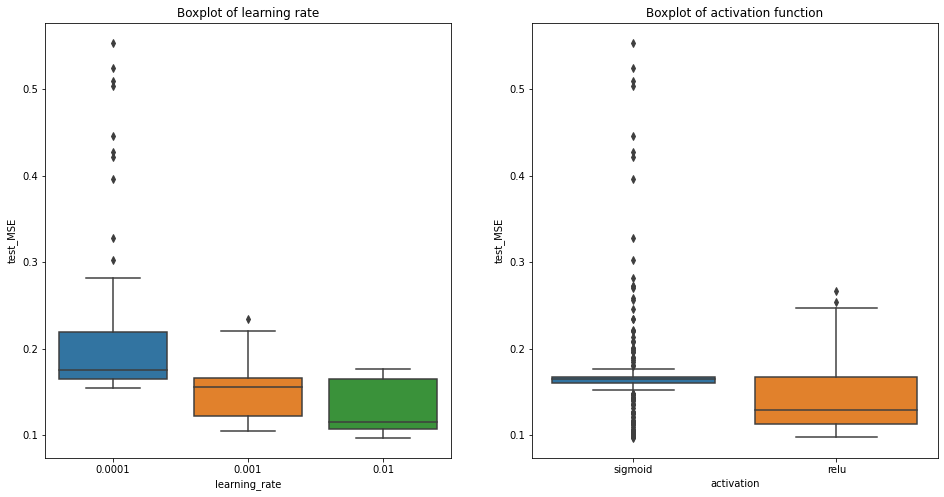

In [97]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

parr_coord_data = runs[variables + target]

sns.boxplot(x=parr_coord_data['learning_rate'], y=parr_coord_data['test_MSE'], ax=ax1)
sns.boxplot(x=parr_coord_data['activation'], y=parr_coord_data['test_MSE'], ax=ax2)

ax1.set_title("Boxplot of learning rate")
ax2.set_title("Boxplot of activation function")